# Compositing

This exercise builds on output from the parallel processing exercise. It does not address how projections and navigation is dealt with in BALTRAD. This should be addressed in a separate exercise.

The Cartesian product area used in this exercise is pre-configured and looked up from a registry.

## Rudimentary composite

In [1]:
%matplotlib inline
import glob, time
import matplotlib
import _raveio, _rave
import _pycomposite, compositing
import warnings

warnings.filterwarnings("ignore")  # Suppress SyntaxWarning from Python2 code

generator = compositing.compositing()
generator.filenames = glob.glob("data/se*.h5")

In [2]:
# Run with all defaults to a pre-configured area that uses the Google Maps projection.
# First two arguments are product date and time. These are taken from the last input file if not specified.
before = time.time()
comp = generator.generate(None, None, area="swegmaps_2000")
after = time.time()

rio = _raveio.new()
rio.object = comp
rio.save("data/comp_pcappi1000m.h5")

print("Compositing took %3.2f seconds" % (after - before))

Compositing took 11.20 seconds


## Tweak the plotter from earlier exercises

In [3]:
# Two color palettes, one used in GoogleMapsPlugin, and the other from RAVE
from GmapColorMap import dbzh as dbzp


# Convert a 768-list palette to a matplotlib colorlist
def make_colorlist(pal):
    colorlist = []
    for i in range(0, len(pal), 3):
        colorlist.append([pal[i] / 255.0, pal[i + 1] / 255.0, pal[i + 2] / 255.0])
    return colorlist


# Convert lists to colormaps
dbzcl = make_colorlist(dbzp)

# Then create a simple plotter
import matplotlib.pyplot as plt

StringType = type("")


def plot(data, colorlist=dbzcl, title="Composite"):
    mini, maxi = data.shape.index(min(data.shape)), data.shape.index(max(data.shape))
    figsize = (20, 16)  # if mini == 0 else (12,8)
    fig = plt.figure(figsize=figsize)
    plt.title(title)
    clist = (
        colorlist
        if type(colorlist) == StringType
        else matplotlib.colors.ListedColormap(colorlist)
    )
    plt.imshow(data, cmap=clist, clim=(0, 255))
    plt.colorbar(shrink=float(data.shape[mini]) / data.shape[maxi])

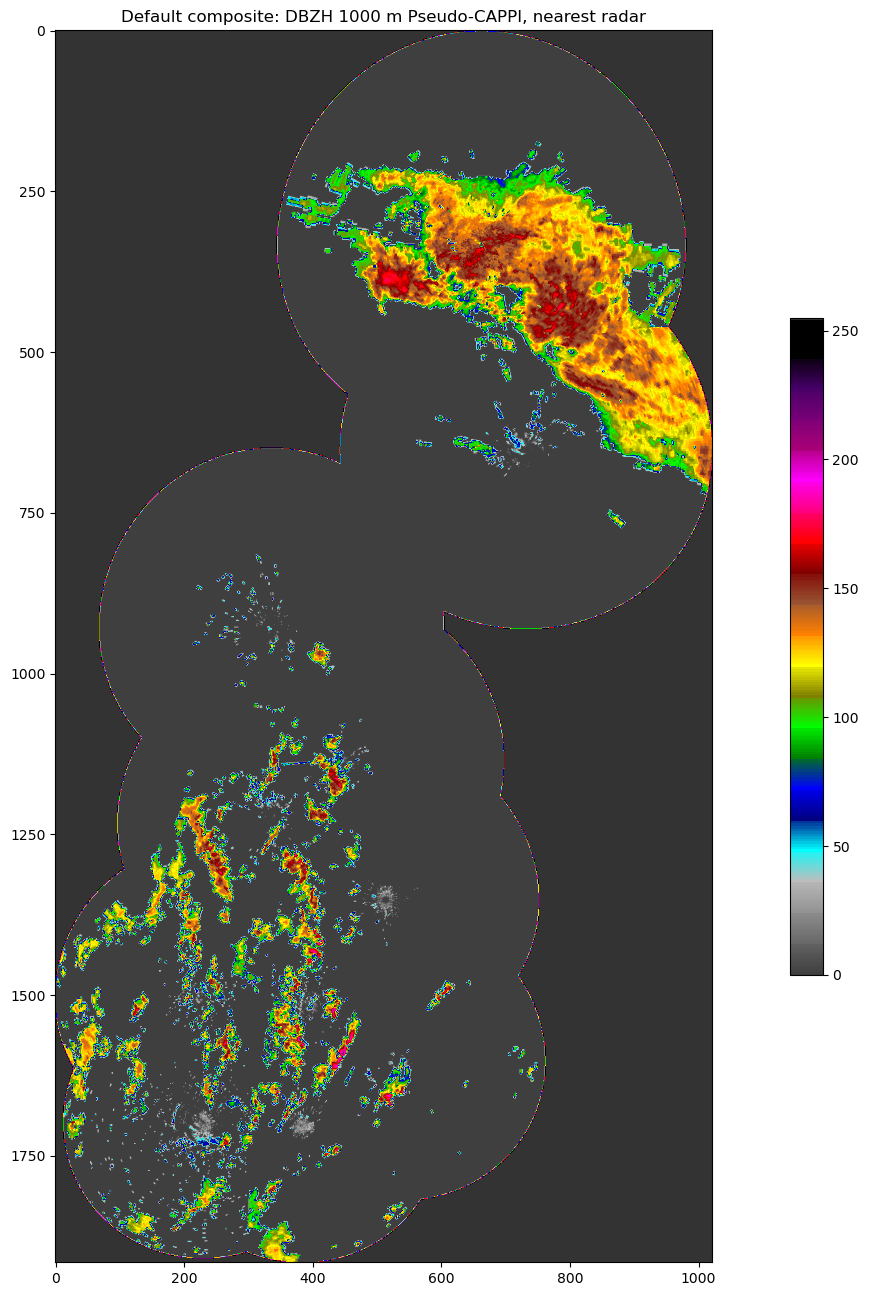

In [4]:
plot(
    comp.getParameter("DBZH").getData(),
    title="Default composite: DBZH 1000 m Pseudo-CAPPI, nearest radar",
)

## Maximum reflectivity, lowest pixel, add QC chain

In [5]:
generator.product = _rave.Rave_ProductType_MAX
generator.selection_method = _pycomposite.SelectionMethod_HEIGHT
generator.detectors = [
    "ropo",
    "beamb",
    "radvol-att",
    "radvol-broad",
    "rave-overshooting",
    "qi-total",
]
before = time.time()
comp = generator.generate(None, None, area="swegmaps_2000")
after = time.time()
rio.object = comp
rio.save("data/comp_max.h5")
print("Compositing took %3.2f seconds" % (after - before))

Compositing took 21.96 seconds


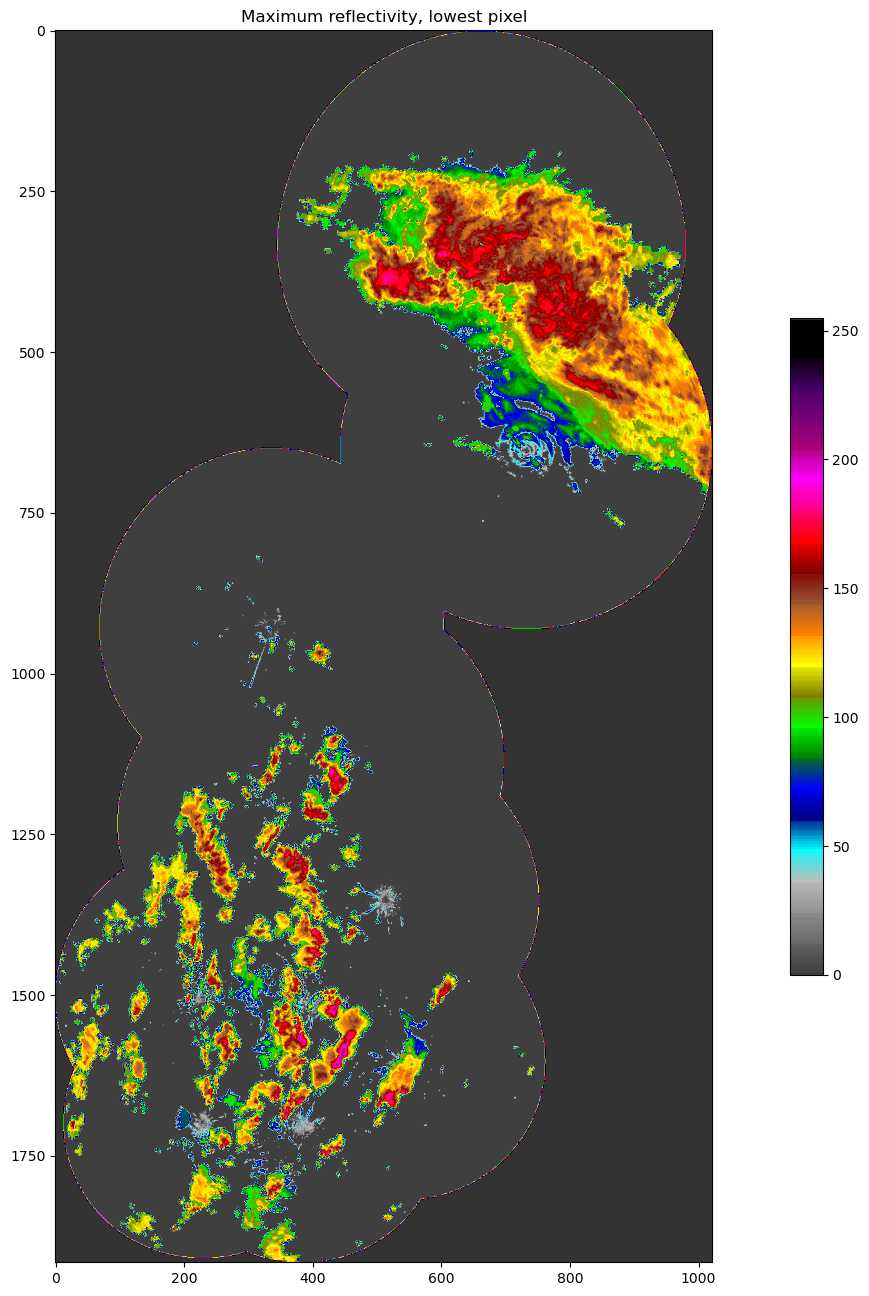

In [6]:
plot(comp.getParameter("DBZH").getData(), title="Maximum reflectivity, lowest pixel")

## Plot correspondong total quality index

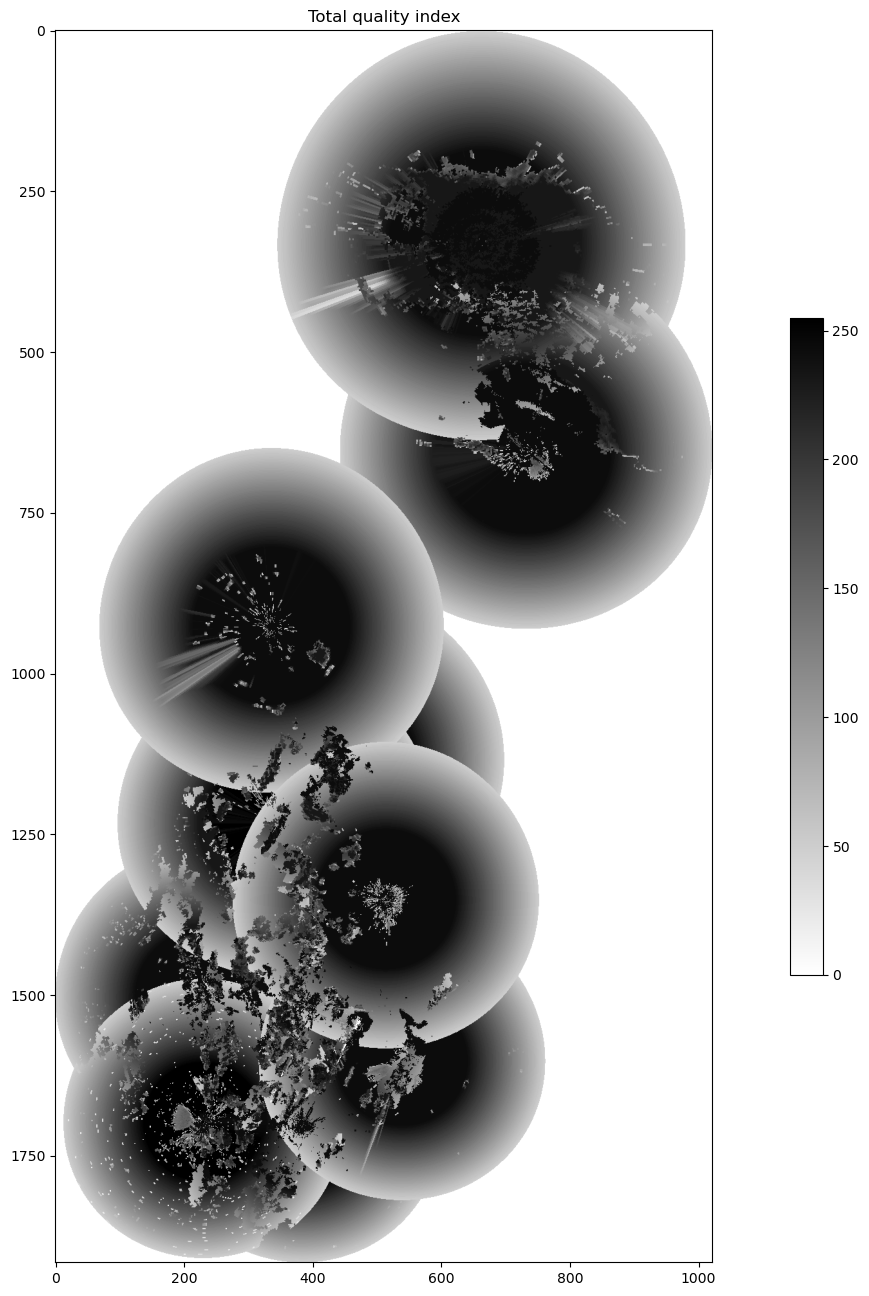

In [7]:
dbzh = comp.getParameter("DBZH")
qitot = dbzh.getQualityFieldByHowTask("pl.imgw.quality.qi_total")
plot(qitot.getData(), "binary", "Total quality index")

## Now use "total quality" as the compositing criterion

In [8]:
generator.qitotal_field = "pl.imgw.quality.qi_total"
before = time.time()
comp = generator.generate(None, None, area="swegmaps_2000")
after = time.time()
rio.object = comp
rio.save("data/comp_qitotal.h5")
print("Compositing took %3.2f seconds" % (after - before))

Compositing took 23.42 seconds


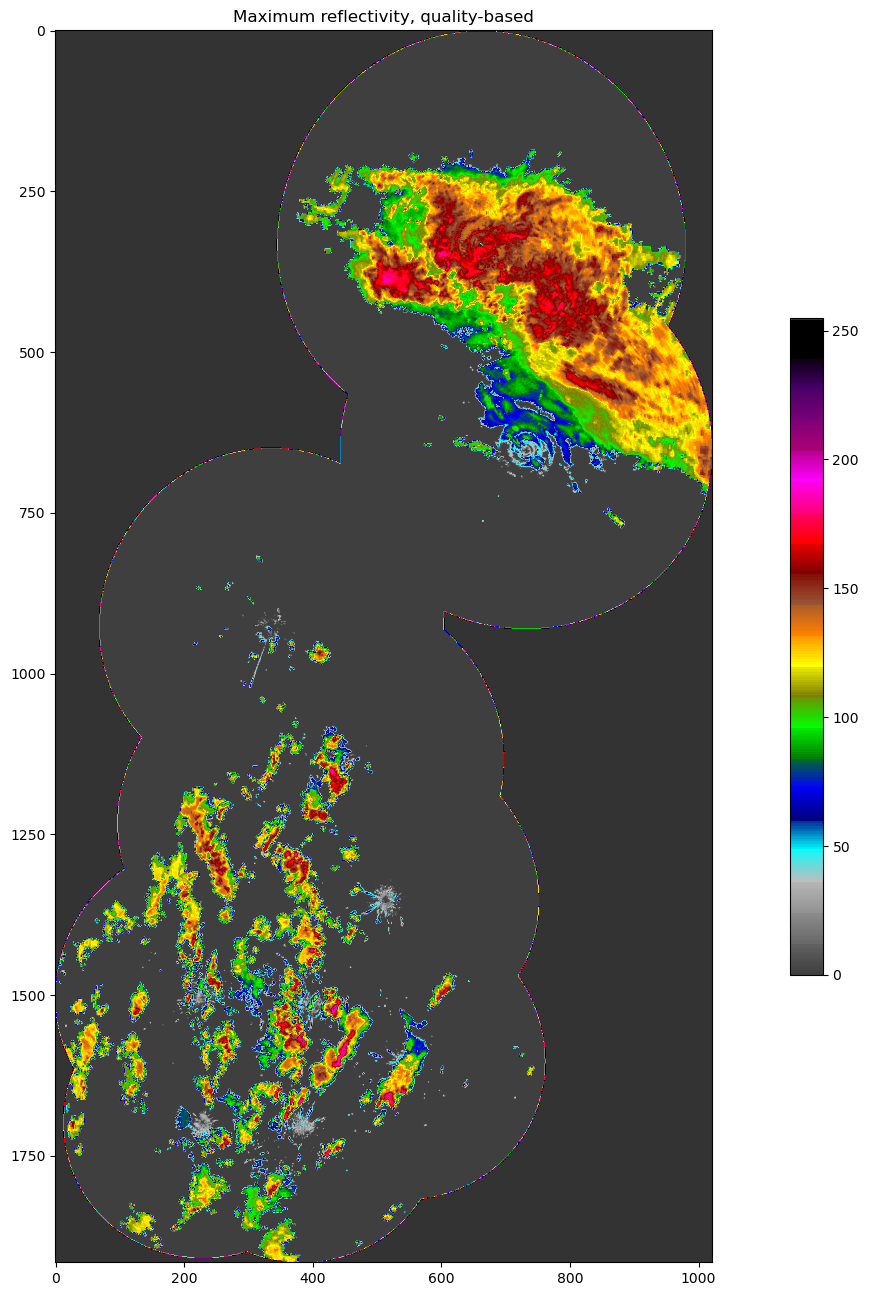

In [9]:
plot(comp.getParameter("DBZH").getData(), title="Maximum reflectivity, quality-based")

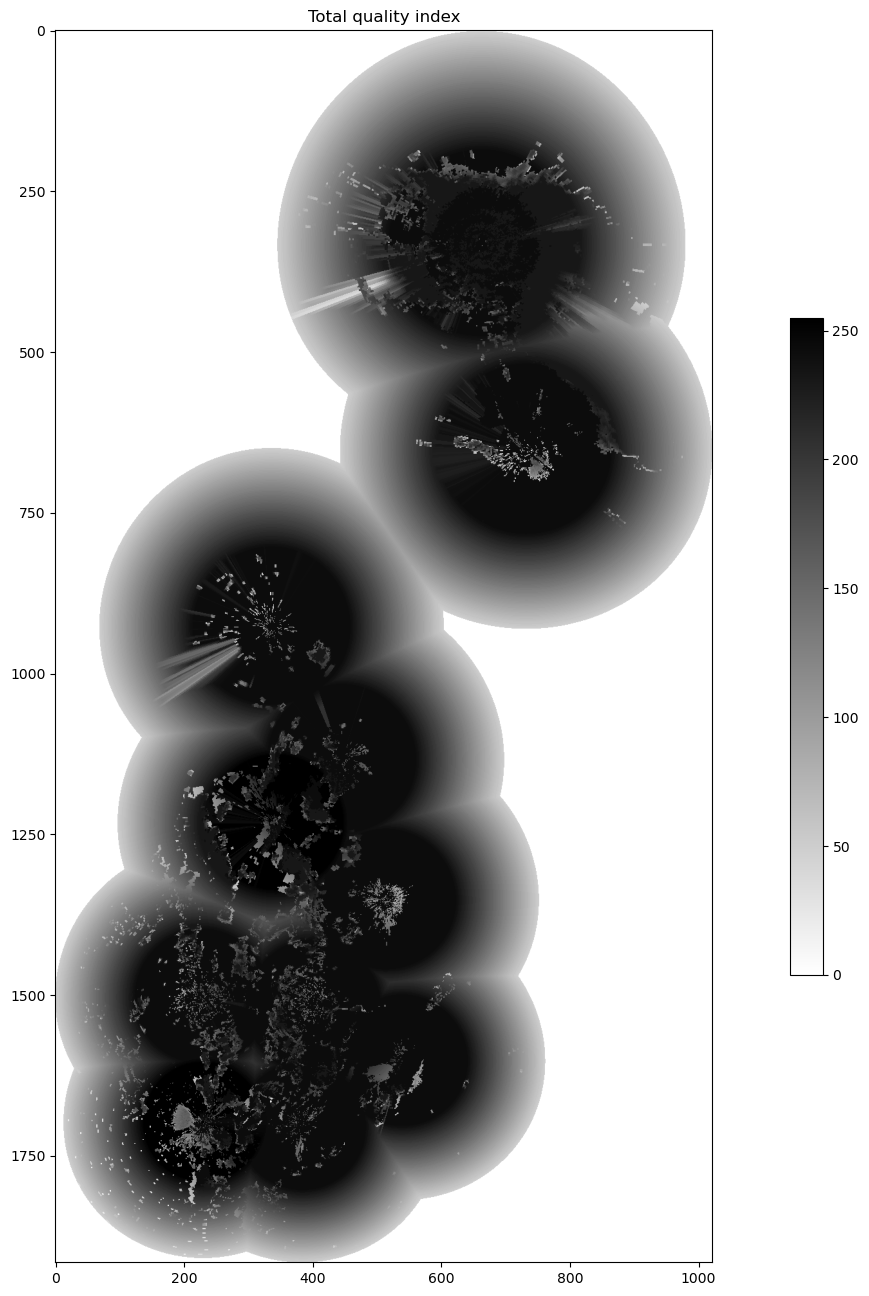

In [10]:
plot(
    comp.getParameter("DBZH")
    .getQualityFieldByHowTask("pl.imgw.quality.qi_total")
    .getData(),
    "binary",
    "Total quality index",
)